# Fine-tuning BERT para Clasificación de Emociones

Implementación de fine-tuning de BERT para clasificar emociones en tweets en español.

## Contenido

1. [Importaciones y Configuración](#1-importaciones-y-configuración)
2. [Carga y Preprocesamiento de Datos](#2-carga-y-preprocesamiento-de-datos)
3. [Configuración del Modelo BERT](#3-configuración-del-modelo-bert)
4. [Entrenamiento del Modelo](#4-entrenamiento-del-modelo)
5. [Evaluación y Métricas](#5-evaluación-y-métricas)

## 1. Importaciones y Configuración

In [16]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
)
from sklearn.preprocessing import label_binarize

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # AdamW ahora está en torch.optim

# Transformers
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    get_linear_schedule_with_warmup,  # Solo importamos el scheduler de transformers
    BertTokenizer, BertModel, BertConfig
)

# Configuración
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Semilla para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Dispositivo utilizado: cuda


## 2. Carga y Preprocesamiento de Datos

Utilizamos los mismos datos que en el notebook RNN, pero adaptamos el preprocesamiento para BERT.

In [17]:
# Cargar los datasets
data_path = '../data/es/'

train_df = pd.read_csv(data_path + 'train.tsv', sep='\t')
dev_df = pd.read_csv(data_path + 'dev.tsv', sep='\t')
test_df = pd.read_csv(data_path + 'test.tsv', sep='\t')

print("Datasets cargados:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(dev_df)} muestras")
print(f"Prueba: {len(test_df)} muestras")

# Crear mapeo de emociones
train_emotions = train_df['emotion'].value_counts()
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(train_emotions.index)}
idx_to_emotion = {idx: emotion for emotion, idx in emotion_to_idx.items()}
num_classes = len(emotion_to_idx)
emotion_names = list(train_emotions.index)

print(f"\nEmociones: {emotion_names}")
print(f"Número de clases: {num_classes}")

Datasets cargados:
Entrenamiento: 5723 muestras
Validación: 844 muestras
Prueba: 1656 muestras

Emociones: ['others', 'joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']
Número de clases: 7


In [18]:
def clean_text_for_bert(text):
    """Limpia texto para BERT (menos agresivo que para RNN)"""
    if pd.isna(text):
        return ""
    
    # BERT maneja mejor el texto original, así que limpieza mínima
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '[USER]', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

def preprocess_dataframe_bert(df):
    """Preprocesa un dataframe para BERT"""
    df = df.copy()
    df['clean_tweet'] = df['tweet'].apply(clean_text_for_bert)
    df['emotion_label'] = df['emotion'].map(emotion_to_idx)
    df = df[df['clean_tweet'].str.len() > 0]
    
    return df

In [19]:
# Aplicar preprocesamiento a todos los datasets
train_clean = preprocess_dataframe_bert(train_df)
dev_clean = preprocess_dataframe_bert(dev_df)
test_clean = preprocess_dataframe_bert(test_df)

print("Resultados del preprocesamiento:")
print(f"Entrenamiento: {len(train_df)} -> {len(train_clean)} muestras")
print(f"Validación: {len(dev_df)} -> {len(dev_clean)} muestras")
print(f"Prueba: {len(test_df)} -> {len(test_clean)} muestras")

Resultados del preprocesamiento:
Entrenamiento: 5723 -> 5723 muestras
Validación: 844 -> 844 muestras
Prueba: 1656 -> 1626 muestras


In [20]:
# Mostrar ejemplos de limpieza
print("\nEjemplos de limpieza de texto para BERT:")
for i in range(3):
    original = train_df.iloc[i]['tweet']
    cleaned = train_clean.iloc[i]['clean_tweet']
    print(f"\nOriginal: {original}")
    print(f"Limpio:   {cleaned}")


Ejemplos de limpieza de texto para BERT:

Original: La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c
Limpio:   La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas [URL] [URL]

Original: El golpe de Estado en #Venezuela está más lejos que el final de Elif. #VenezuelaEnBatallaYVictoria #VenezuelaNoSeRinde #VenezuelaHoy
Limpio:   El golpe de Estado en #Venezuela está más lejos que el final de Elif. #VenezuelaEnBatallaYVictoria #VenezuelaNoSeRinde #VenezuelaHoy

Original: No tengo una foto en la catedral de #NotreDame pero tengo esta secuencia hermosa... https://t.co/cwcdHASGIu
Limpio:   No tengo una foto en la catedral de #NotreDame pero tengo esta secuencia hermosa... [URL]


### 2.1 Configuración del Tokenizador BERT

Configuramos el tokenizador de BERT para texto en español.

In [22]:
# Configurar modelo BERT en español
model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
# Alternativas: 'bertin-project/bertin-roberta-base-spanish', 'PlanTL-GOB-ES/roberta-base-bne'

print(f"Cargando tokenizador: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Configuración de parámetros
max_length = 128  # Longitud máxima para BERT
print(f"Longitud máxima de secuencia: {max_length}")

# Verificar tokens especiales
print(f"\nTokens especiales:")
print(f"CLS token: {tokenizer.cls_token} (ID: {tokenizer.cls_token_id})")
print(f"SEP token: {tokenizer.sep_token} (ID: {tokenizer.sep_token_id})")
print(f"PAD token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"UNK token: {tokenizer.unk_token} (ID: {tokenizer.unk_token_id})")

Cargando tokenizador: dccuchile/bert-base-spanish-wwm-uncased
Longitud máxima de secuencia: 128

Tokens especiales:
CLS token: [CLS] (ID: 4)
SEP token: [SEP] (ID: 5)
PAD token: [PAD] (ID: 1)
UNK token: [UNK] (ID: 3)
Longitud máxima de secuencia: 128

Tokens especiales:
CLS token: [CLS] (ID: 4)
SEP token: [SEP] (ID: 5)
PAD token: [PAD] (ID: 1)
UNK token: [UNK] (ID: 3)


In [25]:
# Ejemplo de tokenización
example_text = train_clean.iloc[0]['clean_tweet']
encoded = tokenizer(
    example_text,
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

print(f"\nEjemplo de tokenización:")
print(f"Texto: {example_text}")
print(f"Input IDs shape: {encoded['input_ids'].shape}")
print(f"Attention mask shape: {encoded['attention_mask'].shape}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][0][:20])}")


Ejemplo de tokenización:
Texto: La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas [URL] [URL]
Input IDs shape: torch.Size([1, 128])
Attention mask shape: torch.Size([1, 128])
Tokens: ['[CLS]', 'la', 'gran', 'guerra', 'de', '[UNK]', 'juego', '##de', '##tron', '##os', 'nos', 'ha', 'dejado', 'muchos', 'momentos', 'para', 'el', 'recuerdo', 'y', 'unas']


### 2.2 Dataset Personalizado para BERT

In [26]:
class BertEmotionDataset(Dataset):
    """Dataset personalizado para BERT y clasificación de emociones"""
    
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row['clean_tweet'])
        label = int(row['emotion_label'])
        
        # Tokenizar
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [27]:
# Crear datasets
train_dataset = BertEmotionDataset(train_clean, tokenizer, max_length)
dev_dataset = BertEmotionDataset(dev_clean, tokenizer, max_length)
test_dataset = BertEmotionDataset(test_clean, tokenizer, max_length)

print(f"Tamaños de datasets:")
print(f"  Entrenamiento: {len(train_dataset)}")
print(f"  Validación: {len(dev_dataset)}")
print(f"  Prueba: {len(test_dataset)}")

Tamaños de datasets:
  Entrenamiento: 5723
  Validación: 844
  Prueba: 1626


In [28]:
# Crear DataLoaders
batch_size = 16  # Menor que RNN debido a BERT ser más pesado

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"Número de batches:")
print(f"  Entrenamiento: {len(train_loader)}")
print(f"  Validación: {len(dev_loader)}")
print(f"  Prueba: {len(test_loader)}")

Número de batches:
  Entrenamiento: 358
  Validación: 53
  Prueba: 102


In [13]:
# Verificar un batch de ejemplo
sample_batch = next(iter(train_loader))
print(f"\nEjemplo de batch:")
print(f"  Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"  Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"  Labels shape: {sample_batch['labels'].shape}")
print(f"  Etiquetas únicas en el batch: {torch.unique(sample_batch['labels']).tolist()}")


Ejemplo de batch:
  Input IDs shape: torch.Size([16, 128])
  Attention mask shape: torch.Size([16, 128])
  Labels shape: torch.Size([16])
  Etiquetas únicas en el batch: [0, 1, 2, 3, 4]


## 3. Configuración del Modelo BERT

### 3.1 Arquitectura del Modelo BERT para Clasificación

In [23]:
class BertEmotionClassifier(nn.Module):
    """Clasificador de emociones basado en BERT"""
    
    def __init__(self, model_name, num_classes, dropout=0.3, freeze_bert=False):
        super(BertEmotionClassifier, self).__init__()
        
        # Cargar modelo BERT preentrenado con trust_remote_code=True y use_safetensors=True
        try:
            self.bert = AutoModel.from_pretrained(
                model_name, 
                trust_remote_code=True,
                use_safetensors=True
            )
        except Exception as e:
            print(f"Error cargando con safetensors: {e}")
            print("Intentando cargar sin safetensors...")
            # Fallback: cargar sin safetensors pero con trust_remote_code
            self.bert = AutoModel.from_pretrained(
                model_name, 
                trust_remote_code=True
            )
        
        # Congelar BERT si se especifica
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # Capas de clasificación
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )
        
        # Inicializar capas de clasificación
        self._init_classifier()
    
    def _init_classifier(self):
        """Inicializa los pesos de las capas de clasificación"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, input_ids, attention_mask):
        """
        Args:
            input_ids: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len)
        Returns:
            logits: (batch_size, num_classes)
        """
        # Pasar por BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Usar el token [CLS] para clasificación
        pooled_output = outputs.pooler_output  # (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output)
        
        # Clasificación
        logits = self.classifier(pooled_output)
        
        return logits

In [24]:
# Configuración del modelo
model_config = {
    'model_name': model_name,
    'num_classes': num_classes,
    'dropout': 0.3,
    'freeze_bert': False  # True para feature extraction, False para fine-tuning
}

# Crear modelo
model = BertEmotionClassifier(**model_config)
model = model.to(device)

# Mostrar información del modelo
def count_parameters(model):
    """Cuenta el número de parámetros entrenables"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Configuración del modelo:")
for key, value in model_config.items():
    print(f"  {key}: {value}")
print(f"\nNúmero total de parámetros entrenables: {total_params:,}")

# Mostrar estructura del clasificador
print(f"\nEstructura del clasificador:")
print(model.classifier)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuración del modelo:
  model_name: dccuchile/bert-base-spanish-wwm-uncased
  num_classes: 7
  dropout: 0.3
  freeze_bert: False

Número total de parámetros entrenables: 110,379,271

Estructura del clasificador:
Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.15, inplace=False)
  (8): Linear(in_features=256, out_features=7, bias=True)
)


In [29]:
# Prueba rápida del modelo
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    input_ids = sample_batch['input_ids'].to(device)
    attention_mask = sample_batch['attention_mask'].to(device)
    
    logits = model(input_ids, attention_mask)
    print(f"Prueba del modelo:")
    print(f"  Input shape: {input_ids.shape}")
    print(f"  Output shape: {logits.shape}")
    print(f"  Logits range: [{logits.min().item():.3f}, {logits.max().item():.3f}]")

Prueba del modelo:
  Input shape: torch.Size([16, 128])
  Output shape: torch.Size([16, 7])
  Logits range: [-4.266, 5.836]


## 4. Entrenamiento del Modelo

### 4.1 Configuración del Entrenamiento

In [30]:
# Configuración del entrenamiento
num_epochs = 10  # Menos epochs para BERT
learning_rate = 2e-5  # Learning rate típico para fine-tuning BERT
weight_decay = 1e-2
warmup_steps = len(train_loader) // 2  # Warmup en la primera mitad del primer epoch

# Optimizador AdamW (recomendado para transformers)
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    eps=1e-8
)

# Scheduler con warmup
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Función de pérdida con pesos de clase
train_emotion_counts = train_clean['emotion'].value_counts()
class_weights = torch.zeros(num_classes)
for emotion, idx in emotion_to_idx.items():
    if emotion in train_emotion_counts:
        class_weights[idx] = 1.0 / train_emotion_counts[emotion]

# Normalizar pesos
class_weights = class_weights / class_weights.sum() * num_classes
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Configuración del entrenamiento:")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Weight decay: {weight_decay}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Total steps: {total_steps}")
print(f"  Optimizador: {optimizer.__class__.__name__}")
print(f"  Pesos de clase: {class_weights.cpu().numpy()}")

Configuración del entrenamiento:
  Learning rate: 2e-05
  Epochs: 10
  Weight decay: 0.01
  Warmup steps: 179
  Total steps: 3580
  Optimizador: AdamW
  Pesos de clase: [0.07596881 0.17335996 0.3069447  0.36114207 0.8937507  1.9163303
 3.2725024 ]


### 4.2 Funciones de Entrenamiento y Evaluación

In [31]:
def train_epoch_bert(model, train_loader, criterion, optimizer, scheduler, device):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_idx, batch in enumerate(train_loader):
        # Mover datos al dispositivo
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        # Estadísticas
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Mostrar progreso cada 50 batches
        if batch_idx % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Accuracy: {100 * correct_predictions / total_predictions:.2f}%, '
                  f'LR: {current_lr:.6f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def evaluate_model_bert(model, data_loader, criterion, device):
    """Evalúa el modelo en un dataset"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # Calcular probabilidades
            probabilities = F.softmax(logits, dim=1)
            
            # Estadísticas
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Guardar para métricas detalladas
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy, all_predictions, all_labels, np.array(all_probabilities)

### 4.3 Bucle Principal de Entrenamiento

In [32]:
# Listas para almacenar las métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Variables para early stopping
best_val_accuracy = 0
patience_counter = 0
max_patience = 3  # Menor paciencia para BERT

print("Iniciando fine-tuning de BERT...")
print("="*80)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-"*40)
    
    # Entrenar
    train_loss, train_acc = train_epoch_bert(model, train_loader, criterion, optimizer, scheduler, device)
    
    # Evaluar en validación
    val_loss, val_acc, _, _, _ = evaluate_model_bert(model, dev_loader, criterion, device)
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Mostrar resultados del epoch
    current_lr = scheduler.get_last_lr()[0]
    print(f"\nResultados del Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Early stopping y guardado del mejor modelo
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        # Guardar mejor modelo
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'model_config': model_config,
            'emotion_to_idx': emotion_to_idx,
            'tokenizer_name': model_name
        }, '../models/best_bert_model.pth')
        print(f"  *** Nuevo mejor modelo guardado (Val Acc: {val_acc:.4f}) ***")
    else:
        patience_counter += 1
        print(f"  Sin mejora. Patience: {patience_counter}/{max_patience}")
    
    # Early stopping
    if patience_counter >= max_patience:
        print(f"\nEarly stopping en epoch {epoch + 1}")
        break

print("\n" + "="*80)
print("Fine-tuning completado!")
print(f"Mejor accuracy de validación: {best_val_accuracy:.4f}")

Iniciando fine-tuning de BERT...

Epoch 1/10
----------------------------------------
Batch 0/358, Loss: 1.5340, Accuracy: 25.00%, LR: 0.000000
Batch 0/358, Loss: 1.5340, Accuracy: 25.00%, LR: 0.000000
Batch 50/358, Loss: 3.3055, Accuracy: 14.83%, LR: 0.000006
Batch 50/358, Loss: 3.3055, Accuracy: 14.83%, LR: 0.000006
Batch 100/358, Loss: 2.8484, Accuracy: 15.84%, LR: 0.000011
Batch 100/358, Loss: 2.8484, Accuracy: 15.84%, LR: 0.000011
Batch 150/358, Loss: 2.2733, Accuracy: 16.56%, LR: 0.000017
Batch 150/358, Loss: 2.2733, Accuracy: 16.56%, LR: 0.000017
Batch 200/358, Loss: 2.7137, Accuracy: 17.54%, LR: 0.000020
Batch 200/358, Loss: 2.7137, Accuracy: 17.54%, LR: 0.000020
Batch 250/358, Loss: 1.7659, Accuracy: 18.05%, LR: 0.000020
Batch 250/358, Loss: 1.7659, Accuracy: 18.05%, LR: 0.000020
Batch 300/358, Loss: 1.8404, Accuracy: 19.06%, LR: 0.000019
Batch 300/358, Loss: 1.8404, Accuracy: 19.06%, LR: 0.000019
Batch 350/358, Loss: 2.1227, Accuracy: 19.84%, LR: 0.000019
Batch 350/358, Loss:

### 4.4 Visualización de Curvas de Entrenamiento

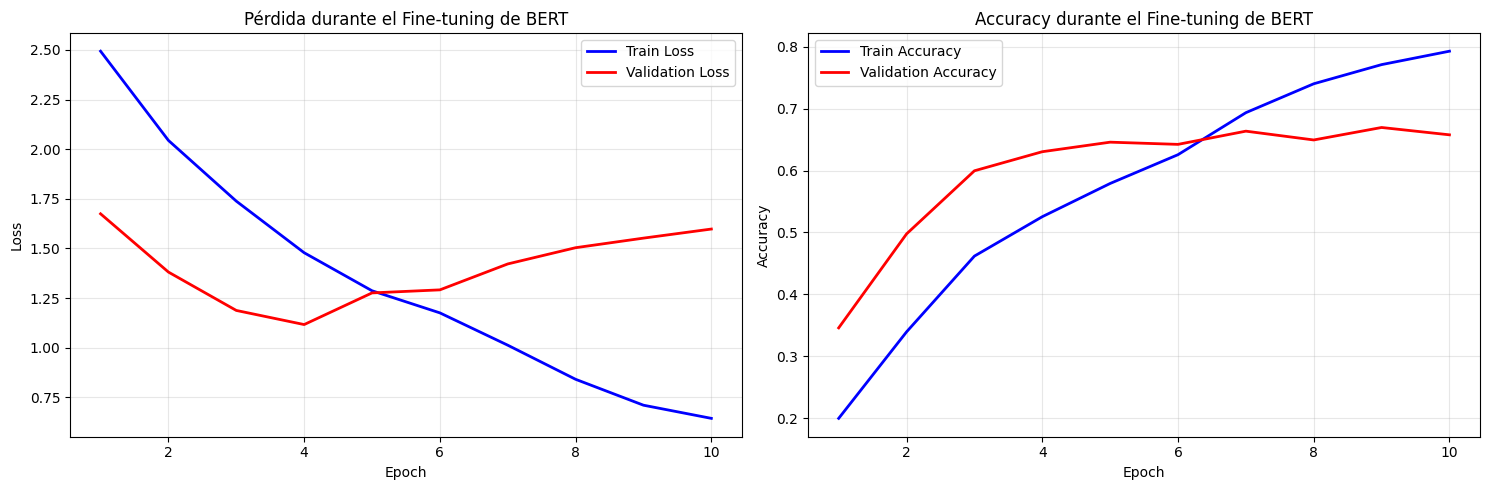


Mejores resultados:
  Epoch: 9
  Train Loss: 0.7106
  Train Accuracy: 0.7709
  Val Loss: 1.5522
  Val Accuracy: 0.6694


In [33]:
# Crear gráficos de las métricas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de pérdida
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Pérdida durante el Fine-tuning de BERT')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de accuracy
ax2.plot(epochs_range, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Accuracy durante el Fine-tuning de BERT')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar mejores resultados
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
print(f"\nMejores resultados:")
print(f"  Epoch: {best_epoch}")
print(f"  Train Loss: {train_losses[best_epoch-1]:.4f}")
print(f"  Train Accuracy: {train_accuracies[best_epoch-1]:.4f}")
print(f"  Val Loss: {val_losses[best_epoch-1]:.4f}")
print(f"  Val Accuracy: {val_accuracies[best_epoch-1]:.4f}")

## 5. Evaluación y Métricas

### 5.1 Carga del Mejor Modelo

In [34]:
# Cargar el mejor modelo
checkpoint = torch.load('../models/best_bert_model.pth', map_location=device)

# Crear nuevo modelo con la misma configuración
best_model = BertEmotionClassifier(**checkpoint['model_config'])
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

print("Mejor modelo BERT cargado exitosamente!")
print(f"Epoch del mejor modelo: {checkpoint['epoch'] + 1}")
print(f"Mejor accuracy de validación: {checkpoint['best_val_accuracy']:.4f}")

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mejor modelo BERT cargado exitosamente!
Epoch del mejor modelo: 9
Mejor accuracy de validación: 0.6694


In [35]:
# Clase EvaluadorMulticlase (reutilizada del notebook RNN)
class EvaluadorMulticlase:
    def __init__(self, classes):
        self.classes = list(classes)

    def show_classification_report(self, y_true_str, y_pred_str, title="Classification report"):
        df_rep = pd.DataFrame(
            classification_report(
                y_true_str, y_pred_str,
                labels=self.classes, target_names=self.classes,
                output_dict=True, zero_division=0
            )
        ).T.round(4)
        print(f"== {title} ==")
        display(df_rep)

    def show_confusion_matrix(self, y_true_str, y_pred_str, title="Matriz de confusión"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])
        y_pred_id = np.array([label2id[x] for x in y_pred_str])

        cm = confusion_matrix(y_true_id, y_pred_id, labels=list(range(len(self.classes))))
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title(title); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout()
        plt.show()

    def show_roc_curves(self, y_true_str, probs, title="Curvas ROC (OvR)"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])

        Y_bin = label_binarize(y_true_id, classes=list(range(len(self.classes))))
        n = len(self.classes)
        rows = int(np.ceil(n/3))
        fig, axes = plt.subplots(rows, 3, figsize=(15, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        auc_macro = None
        try:
            auc_macro = roc_auc_score(Y_bin, probs, average="macro", multi_class="ovr")
        except ValueError:
            pass

        for i, c in enumerate(self.classes):
            r, col = divmod(i, 3)
            ax = axes[r, col]
            try:
                fpr, tpr, _ = roc_curve(Y_bin[:, i], probs[:, i])
                auc_i = roc_auc_score(Y_bin[:, i], probs[:, i])
                ax.plot(fpr, tpr, label=f"AUC={auc_i:.3f}")
            except ValueError:
                ax.plot([0,1],[0,1],'--', lw=1)
                ax.text(0.5, 0.5, "Sin positivos", ha="center")
            ax.plot([0,1],[0,1],'--', lw=1)
            ax.set_title(f"ROC: {c}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right")

        # elimina ejes sobrantes
        total = rows*3
        if total > n:
            for j in range(n, total):
                r, col = divmod(j, 3)
                fig.delaxes(axes[r, col])

        supt = f"{title}" + (f" | AUC macro={auc_macro:.3f}" if auc_macro is not None else "")
        fig.suptitle(supt)
        plt.tight_layout()
        plt.show()

    def show_pr_curves(self, y_true_str, probs, title="Curvas Precision-Recall (OvR)"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])

        Y_bin = label_binarize(y_true_id, classes=list(range(len(self.classes))))
        n = len(self.classes)
        rows = int(np.ceil(n/3))
        fig, axes = plt.subplots(rows, 3, figsize=(15, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, c in enumerate(self.classes):
            r, col = divmod(i, 3)
            ax = axes[r, col]
            try:
                precision, recall, _ = precision_recall_curve(Y_bin[:, i], probs[:, i])
                ap = average_precision_score(Y_bin[:, i], probs[:, i])
                ax.plot(recall, precision, label=f"AP={ap:.3f}")
            except ValueError:
                ax.plot([0,1],[1,0],'--', lw=1)
                ax.text(0.5, 0.5, "Sin positivos", ha="center")
            ax.set_title(f"PR: {c}")
            ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
            ax.legend(loc="lower left")

        total = rows*3
        if total > n:
            for j in range(n, total):
                r, col = divmod(j, 3)
                fig.delaxes(axes[r, col])

        fig.suptitle(title)
        plt.tight_layout()
        plt.show()

    def show_event_analysis(self, df, probs, y_col="emotion", event_col="event", title="Análisis por evento"):
        pred_ids = probs.argmax(axis=1)
        pred_str = np.array([self.classes[i] for i in pred_ids])

        tmp = df[[y_col, event_col]].copy()
        tmp["pred"] = pred_str

        print(f"== {title} ==")
        for event in sorted(tmp[event_col].unique()):
            sub = tmp[tmp[event_col] == event]

            # distribuciones
            dist_real = sub[y_col].value_counts().reindex(self.classes, fill_value=0)
            dist_pred = sub["pred"].value_counts().reindex(self.classes, fill_value=0)

            # métricas
            report = classification_report(
                sub[y_col], sub["pred"],
                labels=self.classes, target_names=self.classes,
                output_dict=True, zero_division=0
            )
            acc = accuracy_score(sub[y_col], sub["pred"])
            f1m = f1_score(sub[y_col], sub["pred"], average="macro")
            prec = report["macro avg"]["precision"]
            rec = report["macro avg"]["recall"]

            # mostrar métricas
            print(f"\nEvento: {event}")
            print(f"  Accuracy:        {acc:.4f}")
            print(f"  F1-macro:        {f1m:.4f}")
            print(f"  Precision-macro: {prec:.4f}")
            print(f"  Recall-macro:    {rec:.4f}")

            # mostrar tablas
            df_dist = pd.DataFrame({
                "Real": dist_real,
                "Pred": dist_pred
            }).astype(int)
            display(df_dist)

### 5.2 Evaluación Completa del Modelo BERT

In [36]:
# Obtener predicciones para el conjunto de test
print("Generando predicciones BERT para el conjunto de test...")
test_loss, test_acc, test_pred_ids, test_true_ids, test_probs = evaluate_model_bert(
    best_model, test_loader, criterion, device
)

# Convertir índices a nombres de emociones
test_pred_emotions = [idx_to_emotion[idx] for idx in test_pred_ids]
test_true_emotions = [idx_to_emotion[idx] for idx in test_true_ids]

print(f"Predicciones generadas para {len(test_pred_emotions)} muestras")
print(f"Accuracy en test: {test_acc:.4f}")

Generando predicciones BERT para el conjunto de test...
Predicciones generadas para 1626 muestras
Accuracy en test: 0.3075
Predicciones generadas para 1626 muestras
Accuracy en test: 0.3075


In [37]:
# Crear instancia del evaluador
evaluador = EvaluadorMulticlase(emotion_names)

print("="*60)
print("EVALUACIÓN COMPLETA DEL MODELO BERT")
print("="*60)

# 1. Reporte de clasificación
evaluador.show_classification_report(
    test_true_emotions,
    test_pred_emotions,
    title="Reporte de Clasificación BERT - Conjunto de Test"
)

EVALUACIÓN COMPLETA DEL MODELO BERT
== Reporte de Clasificación BERT - Conjunto de Test ==


,precision,recall,f1-score,support
others,0.5014,0.4460,0.4721,796.0000
joy,0.2216,0.2414,0.2311,348.0000
sadness,0.1340,0.1333,0.1337,195.0000
anger,0.1509,0.1928,0.1693,166.0000
surprise,0.0256,0.0299,0.0276,67.0000
disgust,0.0000,0.0000,0.0000,33.0000
fear,0.0270,0.0476,0.0345,21.0000
accuracy,0.3075,0.3075,0.3075,0.3075
macro avg,0.1515,0.1558,0.1526,1626.0000
weighted avg,0.3258,0.3075,0.3155,1626.0000


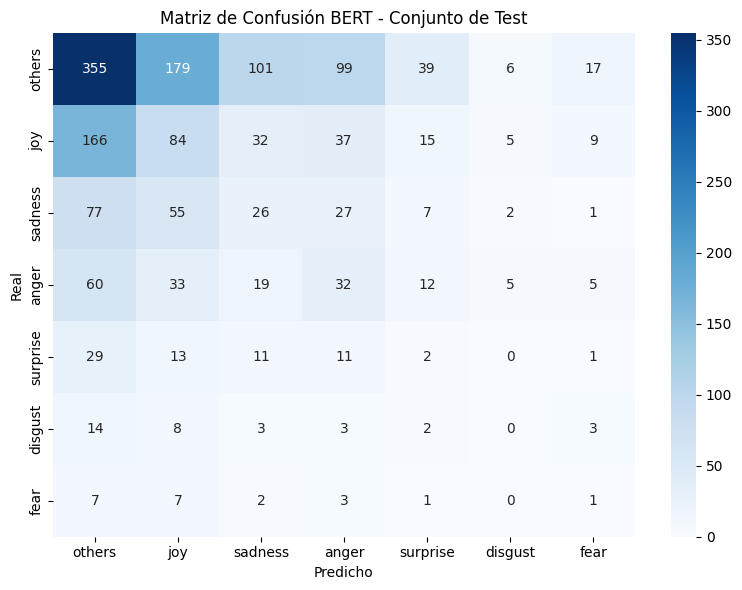

In [38]:
# 2. Matriz de confusión
evaluador.show_confusion_matrix(
    test_true_emotions,
    test_pred_emotions,
    title="Matriz de Confusión BERT - Conjunto de Test"
)

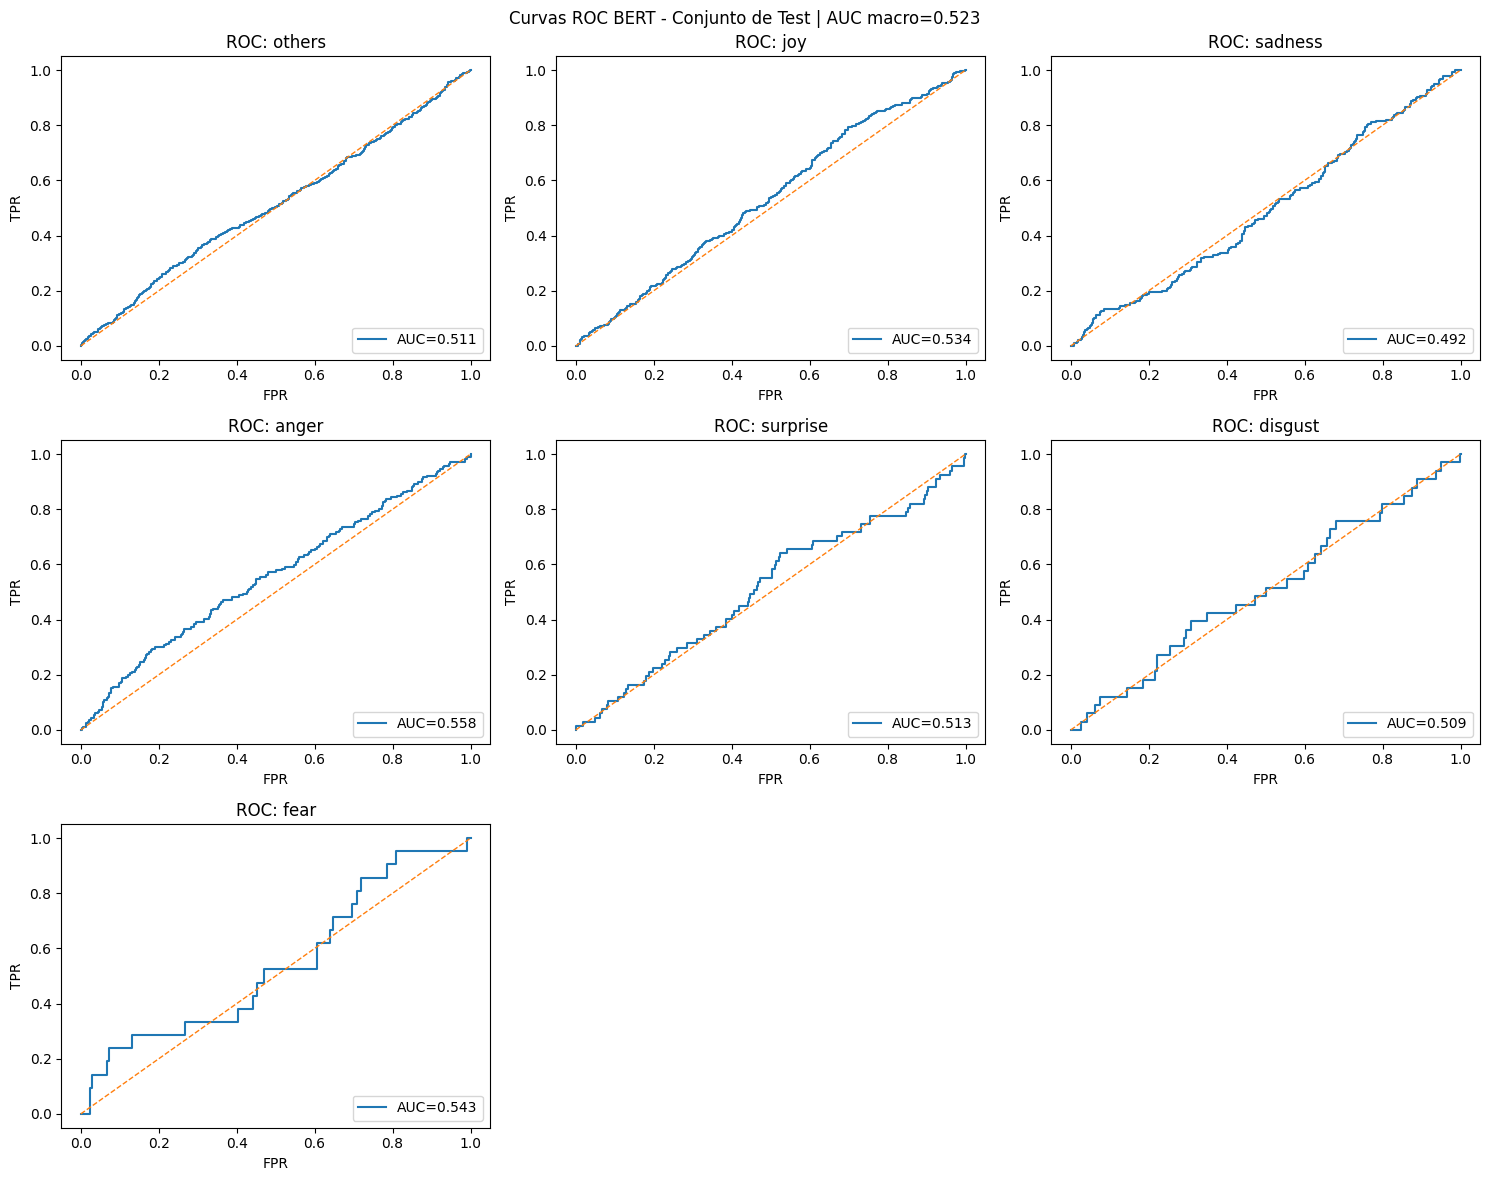

In [39]:
# 3. Curvas ROC
evaluador.show_roc_curves(
    test_true_emotions,
    test_probs,
    title="Curvas ROC BERT - Conjunto de Test"
)

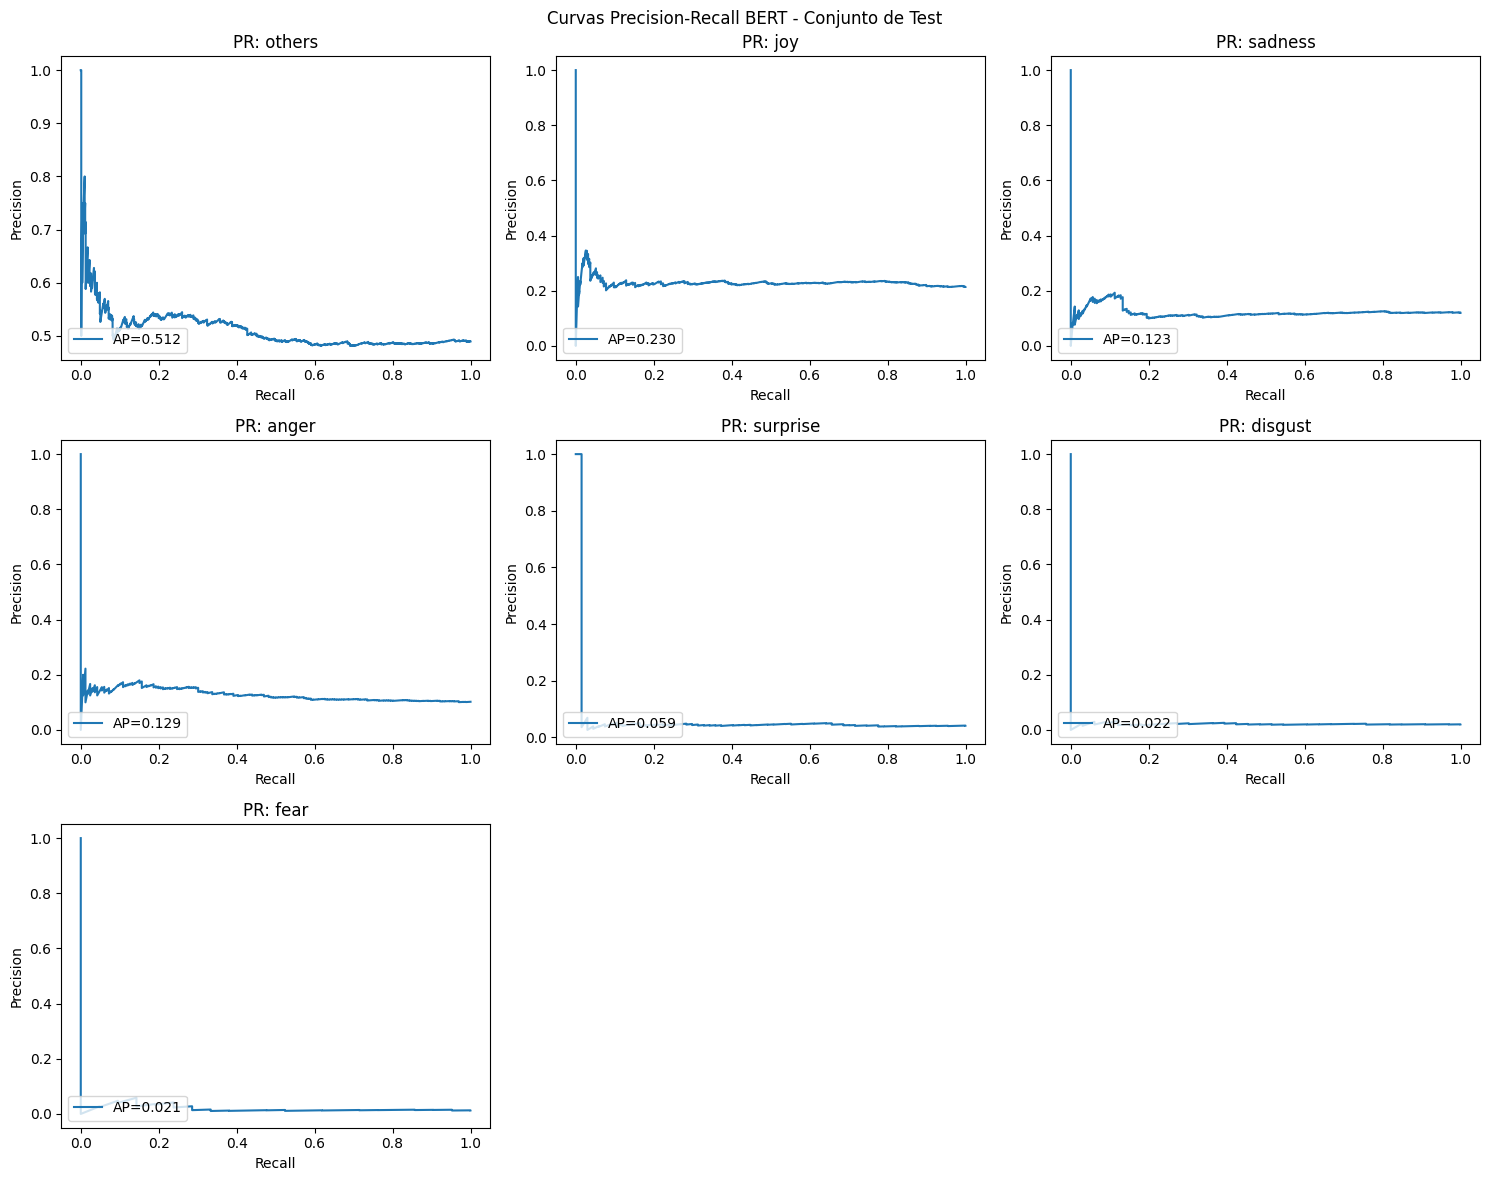

In [40]:
# 4. Curvas Precision-Recall
evaluador.show_pr_curves(
    test_true_emotions,
    test_probs,
    title="Curvas Precision-Recall BERT - Conjunto de Test"
)

In [41]:
# 5. Análisis por evento
evaluador.show_event_analysis(
    test_clean,
    test_probs,
    y_col="emotion",
    event_col="event",
    title="Análisis por Evento BERT - Conjunto de Test"
)

== Análisis por Evento BERT - Conjunto de Test ==

Evento: ChampionsLeague
  Accuracy:        0.3276
  F1-macro:        0.1258
  Precision-macro: 0.1180
  Recall-macro:    0.1361


,Real,Pred
others,99,122
joy,63,75
sadness,27,0
anger,30,24
surprise,5,8
disgust,6,3
fear,2,0



Evento: GameOfThrones
  Accuracy:        0.2557
  F1-macro:        0.1490
  Precision-macro: 0.1522
  Recall-macro:    0.1789


,Real,Pred
others,104,76
joy,47,41
sadness,27,17
anger,22,28
surprise,10,43
disgust,6,2
fear,3,12



Evento: GretaThunberg
  Accuracy:        0.4532
  F1-macro:        0.1477
  Precision-macro: 0.1495
  Recall-macro:    0.1632


,Real,Pred
others,68,108
joy,28,16
sadness,22,4
anger,12,10
surprise,6,1
disgust,1,0
fear,2,0



Evento: LaLiga
  Accuracy:        0.3866
  F1-macro:        0.1224
  Precision-macro: 0.1125
  Recall-macro:    0.1349


,Real,Pred
others,57,73
joy,32,34
sadness,7,5
anger,13,5
surprise,5,0
disgust,3,1
fear,2,1



Evento: NotreDame
  Accuracy:        0.2356
  F1-macro:        0.1109
  Precision-macro: 0.1347
  Recall-macro:    0.1737


,Real,Pred
others,122,45
joy,38,6
sadness,26,135
anger,23,29
surprise,12,8
disgust,4,1
fear,0,1



Evento: SpainElection
  Accuracy:        0.2798
  F1-macro:        0.1442
  Precision-macro: 0.1484
  Recall-macro:    0.1463


,Real,Pred
others,107,84
joy,46,64
sadness,21,11
anger,22,27
surprise,12,14
disgust,5,1
fear,5,17



Evento: Venezuela
  Accuracy:        0.3077
  F1-macro:        0.1423
  Precision-macro: 0.1596
  Recall-macro:    0.1685


,Real,Pred
others,124,91
joy,42,24
sadness,30,17
anger,21,83
surprise,10,3
disgust,3,10
fear,4,6



Evento: WorldBookDay
  Accuracy:        0.3042
  F1-macro:        0.1190
  Precision-macro: 0.1382
  Recall-macro:    0.1337


,Real,Pred
others,115,109
joy,52,119
sadness,35,5
anger,23,6
surprise,7,1
disgust,5,0
fear,3,0


### 5.3 Comparación de Rendimiento

Comparemos el rendimiento del modelo BERT con otros enfoques.

In [42]:
# Métricas finales del modelo BERT
from sklearn.metrics import classification_report

# Reporte detallado
bert_report = classification_report(
    test_true_emotions,
    test_pred_emotions,
    target_names=emotion_names,
    output_dict=True
)

print("\n" + "="*60)
print("RESUMEN FINAL - MODELO BERT")
print("="*60)
print(f"Accuracy: {bert_report['accuracy']:.4f}")
print(f"F1-Score Macro: {bert_report['macro avg']['f1-score']:.4f}")
print(f"F1-Score Weighted: {bert_report['weighted avg']['f1-score']:.4f}")
print(f"Precision Macro: {bert_report['macro avg']['precision']:.4f}")
print(f"Recall Macro: {bert_report['macro avg']['recall']:.4f}")

# Guardar métricas en archivo
results_summary = {
    'model_type': 'BERT',
    'model_name': model_name,
    'accuracy': bert_report['accuracy'],
    'f1_macro': bert_report['macro avg']['f1-score'],
    'f1_weighted': bert_report['weighted avg']['f1-score'],
    'precision_macro': bert_report['macro avg']['precision'],
    'recall_macro': bert_report['macro avg']['recall'],
    'num_epochs_trained': len(train_losses),
    'best_epoch': checkpoint['epoch'] + 1,
    'total_parameters': total_params
}

# Guardar en CSV para comparación posterior
import json
with open('../models/bert_results_summary.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"\nResultados guardados en: ../models/bert_results_summary.json")
print(f"Modelo guardado en: ../models/best_bert_model.pth")


RESUMEN FINAL - MODELO BERT
Accuracy: 0.3075
F1-Score Macro: 0.1526
F1-Score Weighted: 0.3155
Precision Macro: 0.1515
Recall Macro: 0.1558

Resultados guardados en: ../models/bert_results_summary.json
Modelo guardado en: ../models/best_bert_model.pth


## Conclusiones

Este notebook implementa un fine-tuning completo de BERT para clasificación de emociones en español, incluyendo:

1. **Preprocesamiento especializado para BERT**: Menos agresivo que para RNN, preservando más información del texto original
2. **Arquitectura optimizada**: BERT preentrenado + capas de clasificación con regularización
3. **Entrenamiento avanzado**: AdamW + scheduling + warmup + gradient clipping
4. **Evaluación exhaustiva**: Mismas métricas que el modelo RNN para comparación directa

### Ventajas del enfoque BERT:
- Mejor comprensión del contexto bidireccional
- Representaciones más ricas del lenguaje
- Aprovecha conocimiento preentrenado en español
- Generalmente mejor rendimiento en tareas de NLP

### Consideraciones:
- Mayor complejidad computacional
- Más parámetros (>100M vs ~1M en RNN)
- Requiere más memoria GPU
- Entrenamiento más lento